# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [ ]:
#from tensorflow.python.client import device_lib
#print (device_lib.list_local_devices())

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'



from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

# from tensorflow import keras


%matplotlib inline

Using TensorFlow backend.


In [3]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=2,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'lossrec/dataset_mask_epoch-28_loss-5.2064_val_loss-5.9367.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 300, 300, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

In [6]:
model.save('model_inference.h5')

Or

### 1.2. Load a trained model

In [7]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'model_inference.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma


## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [8]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'test_images//mask4.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions

In [9]:
y_pred = model.predict(input_images)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [10]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.97 212.56  20.04 240.97  48.89]
 [  1.     0.86 147.38  34.95 172.34  64.06]
 [  1.     0.61  53.81  30.77  78.23  52.79]
 [  1.     0.55  90.92  48.21 116.55  75.14]]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

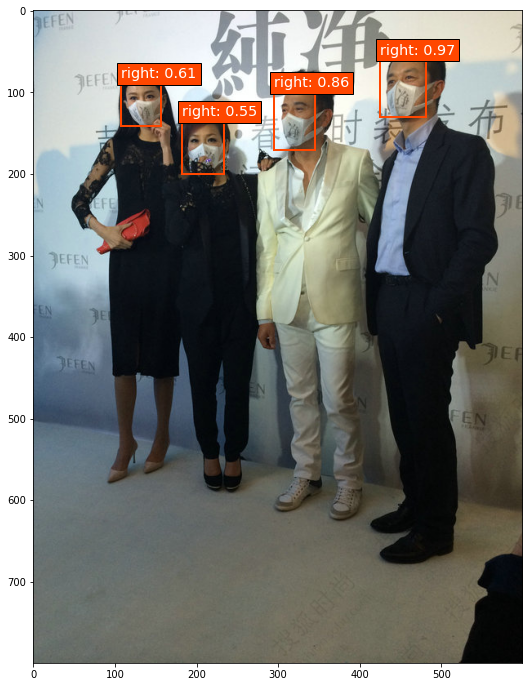

In [11]:
# Display the image and draw the predicted boxes onto it.
 
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'right', 'no']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

# 视频检测

In [12]:
confidence_threshold = 0.5

# Different Classes of objects in VOC dataset
classes = ['background',
            'right', 'no']

height = 300
width  = 300

In [13]:
import imageio
from imageio import imread
import cv2
cv2.__version__

'4.2.0'

In [19]:
input_image_path =  'test_images'
output_image_path = 'test_imagesout'

In [20]:
input_video_path = 'inputs/video/mask/'
output_video_path = 'outputs/video/mask/'

In [21]:
# Transforming image size
def transform(input_image):
	return cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_CUBIC)

In [22]:
# Function to detect objects in image
def detect_object(original_image):
	original_image_height, original_image_width = original_image.shape[:2]
	input_image = transform(original_image)
	input_image = np.reshape(input_image, (1, 300, 300, 3))
	y_pred = model.predict(input_image)
	actual_prediction = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
	for box in actual_prediction[0]:
		# Coordinates of diagonal points of bounding box
		x0 = box[-4] * original_image_width / width
		y0 = box[-3] * original_image_height / height
		x1 = box[-2] * original_image_width / width
		y1 = box[-1] * original_image_height / height
		label_text = '{}: {:.2f}'.format(classes[int(box[0])], box[1])	# label text
		cv2.rectangle(original_image, (int(x0), int(y0)), (int(x1), int(y1)), (255, 0, 0), 2)	# drwaing rectangle
		cv2.putText(original_image, label_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_DUPLEX, 1, (231, 237, 243), 2, cv2.LINE_AA) # putting lable
	return original_image

In [23]:
%%time

# Detecting objects in images
for file in os.listdir(input_image_path):
	print('Reading', file)  
	original_image = imageio.imread(os.path.join(input_image_path, file))	# Reading image
	if original_image is not None:
		output_image = detect_object(original_image)	# detecting objects
		imageio.imwrite(os.path.join(output_image_path, file), output_image[:, :, :])	# savinng back images

Reading mask2.jpg
Reading mask4.jpg
Reading mask3.jpg
Reading mask1.jpg
CPU times: user 6.45 s, sys: 61.4 ms, total: 6.51 s
Wall time: 705 ms


In [24]:
%%time

# Detecting objects in images
for file in os.listdir(input_image_path):
	print('Reading', file)  
	original_image = imageio.imread(os.path.join(input_image_path, file))	# Reading image
	if original_image is not None:
		output_image = detect_object(original_image)	# detecting objects
		imageio.imwrite(os.path.join(output_image_path, file), output_image[:, :, :])	# savinng back images

Reading mask2.jpg
Reading mask4.jpg
Reading mask3.jpg
Reading mask1.jpg
CPU times: user 6.36 s, sys: 39.2 ms, total: 6.4 s
Wall time: 704 ms


In [123]:
%%time

# Detecting objects in video
for file in os.listdir(input_video_path):
	print('Reading', file)
	video_reader = imageio.get_reader(os.path.join(input_video_path, file))	# Reading video
	fps = video_reader.get_meta_data()['fps']	# gettinf fps of the image
	video_writer = imageio.get_writer(os.path.join(output_video_path, file), fps = fps)	# Writing back output image
	for i, frame in enumerate(video_reader):
		output_frame = detect_object(frame)	# detecting objects frame by frame
		video_writer.append_data(output_frame)	# appending frame to vidoe
		print('frame ', i, 'done')
	video_writer.close()

Reading mask1.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (480, 270) to (480, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame  0 done
frame  1 done
frame  2 done
frame  3 done
frame  4 done
frame  5 done
frame  6 done
frame  7 done
frame  8 done
frame  9 done
frame  10 done
frame  11 done
frame  12 done
frame  13 done
frame  14 done
frame  15 done
frame  16 done
frame  17 done
frame  18 done
frame  19 done
frame  20 done
frame  21 done
frame  22 done
frame  23 done
frame  24 done
frame  25 done
frame  26 done
frame  27 done
frame  28 done
frame  29 done
frame  30 done
frame  31 done
frame  32 done
frame  33 done
frame  34 done
frame  35 done
frame  36 done
frame  37 done
frame  38 done
frame  39 done
frame  40 done
frame  41 done
frame  42 done
frame  43 done
frame  44 done
frame  45 done
frame  46 done
frame  47 done
frame  48 done
frame  49 done
frame  50 done
frame  51 done
frame  52 done
frame  53 done
frame  54 done
frame  55 done
frame  56 done
frame  57 done
frame  58 done
frame  59 done
frame  60 done
frame  61 done
frame  62 done
frame  63 done
frame  64 done
frame  65 done
frame  66 done
frame

frame  519 done
frame  520 done
frame  521 done
frame  522 done
frame  523 done
frame  524 done
frame  525 done
frame  526 done
frame  527 done
frame  528 done
frame  529 done
frame  530 done
frame  531 done
frame  532 done
frame  533 done
frame  534 done
frame  535 done
frame  536 done
frame  537 done
frame  538 done
frame  539 done
frame  540 done
frame  541 done
frame  542 done
frame  543 done
frame  544 done
frame  545 done
frame  546 done
frame  547 done
frame  548 done
frame  549 done
frame  550 done
frame  551 done
frame  552 done
frame  553 done
frame  554 done
frame  555 done
frame  556 done
frame  557 done
frame  558 done
frame  559 done
frame  560 done
frame  561 done
frame  562 done
frame  563 done
frame  564 done
frame  565 done
frame  566 done
frame  567 done
frame  568 done
frame  569 done
frame  570 done
frame  571 done
frame  572 done
frame  573 done
frame  574 done
frame  575 done
frame  576 done
frame  577 done
frame  578 done
frame  579 done
frame  580 done
frame  5

# 本地视频实时检测

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
%%time

from IPython.display import Video
Video("inputs/video/mask/mask1.mp4")

CPU times: user 83 µs, sys: 8 µs, total: 91 µs
Wall time: 101 µs


In [27]:
from IPython.display import Video
Video("outputs/video/mask.mp4")

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

# 调用摄像头实时检测

In [28]:
%%time 
video_capture = cv2.VideoCapture(0) 
while video_capture.isOpened():
    _, frame = video_capture.read() 
    canvas = detect_object(frame)
    cv2.imshow('Video', canvas) 
    if cv2.waitKey(1) & 0xFF == ord('q'): # Press q to Escape 
        break 

video_capture.release() 
cv2.destroyAllWindows() 

CPU times: user 1h 55min 9s, sys: 1min 7s, total: 1h 56min 16s
Wall time: 11min 28s


## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [ ]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# TODO: Set the paths to the datasets here.

VOC_2007_images_dir         = '../../datasets/VOCdevkit/VOC2007/JPEGImages/'
VOC_2007_annotations_dir    = '../../datasets/VOCdevkit/VOC2007/Annotations/'
VOC_2007_test_image_set_filename = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                  image_set_filenames=[VOC_2007_test_image_set_filename],
                  annotations_dirs=[VOC_2007_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

In [ ]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

In [ ]:
# Predict.

y_pred = model.predict(batch_images)

In [ ]:
confidence_threshold = 0.5

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

In [ ]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})